 # Boltz-2 NIM: Protein–Ligand Co-Folding and Affinity Prediction

 **Boltz-2 NIM** is designed to predict protein-ligand co-folding secondary structures and binding affinities. This demo also includes **MSA-Search NIM** for improved sequence alignment, protein folding, and enhanced ligand–protein interaction prediction.

 ## Demo

 - **Platform**: Google Colab
 - **Date**: 08 Sept 2025

 ## Case Study: RORc Nuclear Receptor Antagonists

 This demo uses ligand chemical structures (SMILES) and pIC₅₀ values from the following publications:

 - *BMCL* **2014**, p.2182 https://www.sciencedirect.com/science60894X14002546
 - *BMCL* **2014**, p.3891 https://www.sciencedirect.com/science/article006763
 - *JMC* **2015**, p.5308 https://pubs.acs.org/doi/10.1021/

 ### NVIDIA NIMs (NVIDIA Inference Microservices)

 [MSA-Search](https://docs.nvidia.com/nim/bionemo/msa-search/latest/overview.html) Multiple Sequence Alignment (MSA) compares a query amino acid sequence to protein databases, aligning similar sequences to identify conserved regions despite differences in length or motifs. The resulting alignments enhance structural prediction models like AlphaFold2 and OpenFold by leveraging the structural similarity of homologous sequences.

 [Boltz-2](https://docs.nvidia.com/nim/bionemo/boltz2/latest/index.html) Boltz-2 NIM delivers advanced biomolecular structure and binding affinity predictions for proteins, RNA, DNA, and other molecules. Built on the Boltz-2 architecture, it enables accurate modeling of complex structures and quantifies molecular interactions across diverse configurations.

## 1.1 Setup the environment

In [ ]:
!pip install matplotlib numpy pandas scikit-learn tqdm httpx

In [ ]:
import os, requests, re, sys, shutil, logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from pathlib import Path
from typing import Dict, Any, Optional, Tuple, List
from time import perf_counter, sleep
from tqdm import tqdm
from datetime import datetime
from google.colab import userdata, files

# Check for required dependencies
missing_deps = []
try:
    import httpx
except ImportError:
    missing_deps.append("httpx")

if missing_deps:
    print("Error: Missing required dependencies. Please install them using:")
    print(f"pip install {' '.join(missing_deps)}")
    sys.exit(1)

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

### Define input file with SMILES data and output directory

In [ ]:
# edit to match your dataset path. Ensure you use the `raw` URL path if the file is hosted on GitHub.

CSV_FILE = "https://raw.githubusercontent.com/bf-nv/bionemo_tutorials/refs/heads/main/RORc_SMILES_and_pIC50.csv"
# CSV_FILE = "RORc_SMILES_and_pIC50.csv"

OUTPUT_DIR = "/content/output"

## 1.2 Setup `output` directory and `API_KEY`

NOTE: Be sure to follow the steps in the [README](https://github.com/bf-nv/bionemo_tutorials/blob/main/README.md) to embed your NVIDIA `API_KEY` into your Google Colab environment.

In [ ]:
API_KEY = userdata.get('API_KEY')

# Ensure output directory exists, create if not present
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
    os.makedirs(OUTPUT_DIR)

## 1.3 Define `MSA-Search` functions

In [ ]:
MSA_DATABASES = ['Uniref30_2302', 'colabfold_envdb_202108', 'PDB70_220313']

def msa_search(sequence, API_KEY, databases=MSA_DATABASES):
    msa_search_url = "https://health.api.nvidia.com/v1/biology/colabfold/msa-search/predict"
    payload = {
        "sequence": sequence,
        "databases": databases,
        "e_value": 0.0001,
        "iterations": 1,
        "max_msa_sequences": 10000,
        "run_structural_template_search": False,
        "output_alignment_formats": ["a3m"],
    }
    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "content-type": "application/json",
        "NVCF-POLL-SECONDS": "300",
    }
    # Call MSA-Search NIM
    response = requests.post(msa_search_url, json=payload, headers=headers)
    return response.json()


def parse_sequences(input_string, n, sequence):
    """
    Parse the output of alignments from the MSA-Search NIM to be used downstream

    Args:
        input_string (str): The output file of alignments in a string format
        n (int): The amount of alignments to return from the output when parsing
        sequence (str): The query sequence for alignment

    Returns:
        list: A list of alignment identifiers and sequences, starting with the query,
              where the amount of sequences is given by n
    """
    # Output is parsed to have a line for the sequence id and sequence itself so `n` returns correlates to n*2 lines
    n = n * 2
    # Regex to find blocks starting with `>` and then followed by a sequence.
    pattern = re.compile(r'\n>(.*?)\n(.*?)(?=\n>|\Z)', re.DOTALL)
    matches = pattern.finditer(input_string)
    output_list_to_order = []
    for match in matches:
        # The name is the first capturing group, split by tab and take the first part
        name_full = match.group(1).split('\t')[0]
        SW_score = match.group(1).split('\t')[1]
        # The sequence is the second capturing group
        sequence_raw = match.group(2).strip()
        aligned_sequence = ''.join(char for char in sequence_raw if char.isupper() or char == '-')
        # Store the aligned sequence in the list of outputs by name, sequence, Smith-Waterman score
        output_list_to_order.append((f'>{name_full}', aligned_sequence, int(SW_score)))
    output_lines = output_list_to_order[:n]
    return output_lines


def validate_a3m_format(alignments_string):
    """
    Validate that the alignment string follows A3M format.

    Args:
        alignments_string (str): String containing alignments

    Returns:
        bool: True if valid A3M format, False otherwise
    """
    lines = alignments_string.strip().split('\n')
    if len(lines) < 2:
        return False

    # Check that we have alternating header and sequence lines
    valid_aa_chars = set('ACDEFGHIKLMNPQRSTVWY-')
    for i, line in enumerate(lines):
        if i % 2 == 0:  # Even indices should be headers
            if not line.startswith('>'):
                return False
        else:  # Odd indices should be sequences
            if line.startswith('>'):
                return False
            # Sequences should only contain valid amino acid characters and gaps
            if not all(c in valid_aa_chars for c in line.upper()):
                return False
    return True


def write_alignments_to_a3m(alignments_data, uniprot_id, output_dir):
    """
    Write alignment data to a3M format file.

    Args:
        alignments_data: Either a list of alternating headers/sequences or a string containing alignments
        uniprot_id (str): Uniprot ID of the protein
        output_dir (str): Directory for the output a3M file

    Returns:
        str: Path to the created a3M file
    """
    # Ensure output directory exists
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    output_path = Path(output_dir) / f"{uniprot_id}_msa_alignments.a3m"

    # Handle both list and string input formats
    if isinstance(alignments_data, list):
        alignments_string = '\n'.join(alignments_data)
    elif isinstance(alignments_data, str):
        alignments_string = alignments_data
    else:
        raise ValueError("alignments_data must be either a list or string")

    # Validate A3M format
    if not alignments_string.strip():
        raise ValueError("Empty alignment data provided")

    # Count sequences for reporting
    sequence_count = alignments_string.count('>')
    if sequence_count == 0:
        raise ValueError("No sequences found in alignment data")

    # Validate A3M format structure
    if not validate_a3m_format(alignments_string):
        print("Warning: Alignment data may not follow strict A3M format")
        print("Proceeding with file creation...")

    print(f"Writing {sequence_count} sequences to A3M format: {output_path}")

    try:
        with open(output_path, 'w', encoding='utf-8') as f:
            # Write the alignments
            f.write(alignments_string)
            # Ensure file ends with newline
            if not alignments_string.endswith('\n'):
                f.write('\n')

        # Verify the file was created successfully
        if output_path.exists():
            file_size = output_path.stat().st_size
            print(f"Successfully created A3M file:")
            print(f"File: {output_path}")
            print(f"Size: {file_size:,} bytes")
            print(f"Sequences: {sequence_count}")

            # Download the file to the user's machine
            try:
                files.download(str(output_path))
                print(f"File downloaded successfully: {output_path}")
            except Exception as download_error:
                print(f"Warning: Could not download file automatically: {download_error}")
                print(f"File is available at: {output_path}")

            return str(output_path)
        else:
            raise IOError(f"Failed to create file {output_path}")
    except Exception as e:
        print(f"Error writing A3M file: {e}")
        raise


def process_msa_alignments(msa_response_dict, sequence, uniprot_id, output_dir, databases=MSA_DATABASES, max_sequences_per_db=10000):
    """
    Process MSA alignments from multiple databases and merge them into A3M format.

    Args:
        msa_response_dict (dict): MSA response data containing alignments
        sequence (str): Query sequence for alignment
        uniprot_id (str): Uniprot ID of the protein
        output_dir (str): Output directory for the A3M file
        databases (list): List of database names to process
        max_sequences_per_db (int): Maximum number of sequences to parse per database

    Returns:
        str: Path to the created A3M file
    """
    all_parsed_dataset_output = []
    for database in databases:
        print(f"Parsing results from database: {database}")
        # Pull string of alignments stored in json output for specific dataset
        alignment_data = msa_response_dict['alignments'][database]['a3m']['alignment']
        parsed_alignments = parse_sequences(alignment_data, max_sequences_per_db, sequence)
        print(f"Number of sequences aligned: {len(parsed_alignments)}")
        all_parsed_dataset_output.extend(parsed_alignments)
    # Sort all the alignments based off of the alignment score
    all_parsed_dataset_output.sort(key=lambda x: x[2], reverse=True)
    # Now that the alignments across all datasets are sorted, reformat each entry to name and sequence
    sorted_parsed_output_formatted = []
    for align_tuple in all_parsed_dataset_output:
        sorted_parsed_output_formatted.extend([align_tuple[0], align_tuple[1]])
    merged_alignments_protein = [f">query_sequence\n{sequence}"] + sorted_parsed_output_formatted
    print(f"Total merged alignments: {len(merged_alignments_protein)}")
    # Write merged_alignments_protein to a3M format
    a3m_file_path = write_alignments_to_a3m(
        merged_alignments_protein,
        uniprot_id,
        output_dir
    )
    return a3m_file_path

## 1.4 Run `MSA-Search` and save `A3M` alignment file output to local directory

### Provide sequence information
**NOTE:** Ensure the sequence is a string and does not contain any whitespace, special characters, nor carriage returns.

In [ ]:
# Example sequence using human RORc from PDB:4wqp
# http://rcsb.org/structure/4WQP

# >4WQP_1|Chain A|Nuclear receptor ROR-gamma|Homo sapiens (9606)
uniprot_id = "4wqp_1"
sequence = "MHHHHHHGENLYFQGSAPYASLTEIEHLVQSVCKSYRETCQLRLEDLLRQRSNIFSREEVTGYQRKSMWEMWERCAHHLTEAIQYVVEFAKRLSGFMELCQNDQIVLLKAGAMEVVLVRMCRAYNADNRTVFFEGKYGGMELFRALGCSELISSIFDFSHSLSALHFSEDEIALYTALVLINAHRPGLQEKRKVEQLQYNLELAFHHHLCKTHRQSILAKLPPKGKLRSLCSQHVERLQIFQHLHPIVVQAAFPPLYKELFSGNS"
sequences = [(uniprot_id, sequence)]

# NOTE: Ensure the sequence is a string and does not contain any whitespace, special characters, nor carriage returns.

In [ ]:
for seq_id, seq in tqdm(sequences):
    try:
        print(f"\nProcessing protein: {seq_id}")
        print(f"Sequence length: {len(seq)}")

        # Call MSA-Search NIM
        msa_response_dict = msa_search(seq, API_KEY)

        # Check if the response contains the expected data
        if 'alignments' not in msa_response_dict:
            print(f"Warning: No alignments found for {seq_id}")
            continue

        # Process and create A3M file
        a3m_file_path = process_msa_alignments(msa_response_dict, seq, seq_id, OUTPUT_DIR)
        print(f"Successfully processed {seq_id} -> {a3m_file_path}")

    except Exception as e:
        print(f"Error processing {seq_id}: {e}")
        continue

  0%|          | 0/1 [00:00<?, ?it/s]


Processing protein: 4wqp_1
Sequence length: 265
Parsing results from database: Uniref30_2302
Number of sequences aligned: 100
Parsing results from database: colabfold_envdb_202108
Number of sequences aligned: 100
Parsing results from database: PDB70_220313
Number of sequences aligned: 88
Total merged alignments: 577
Proceeding with file creation...
Writing 289 sequences to A3M format: /content/output/4wqp_1_msa_alignments.a3m
Successfully created A3M file:
File: /content/output/4wqp_1_msa_alignments.a3m
Size: 81,161 bytes
Sequences: 289


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 1/1 [00:38<00:00, 38.67s/it]

File downloaded successfully: /content/output/4wqp_1_msa_alignments.a3m
Successfully processed 4wqp_1 -> /content/output/4wqp_1_msa_alignments.a3m


## 1.5 List all created `A3M` alignment files

In [ ]:
# List all created A3M files
a3m_files = list(Path(OUTPUT_DIR).glob("*.a3m"))
a3m_files = sorted(a3m_files)
print(f"Created {len(a3m_files)} A3M files:")
for file_path in a3m_files:
    file_size = Path(file_path).stat().st_size
    print(f"  - {Path(file_path).name} ({file_size:,} bytes)")

print(f"\nAll A3M files are available in: {OUTPUT_DIR}")
print("Files have been automatically downloaded to your machine.")

Created 1 A3M files:
  - 4wqp_1_msa_alignments.a3m (81,161 bytes)

All A3M files are available in: /content/output
Files have been automatically downloaded to your machine.


## 1.6 If needed, trigger download of all `A3M` alignment files to local machine

In [ ]:
for file_path in a3m_files:
    files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2.1 Set-up `Boltz-2` environment

### Configuration constraints

In [ ]:
# MSA configuration
MSA_FILE_PATH = Path(OUTPUT_DIR) / f"{uniprot_id}_msa_alignments.a3m"
MSA_STATUS = MSA_FILE_PATH.exists()

# Sequence configuration
SEQUENCE_ID = uniprot_id
SEQUENCE_STRING = sequence

# Boltz2 parameters
STATUS_URL = "https://api.nvcf.nvidia.com/v2/nvcf/pexec/status/{task_id}"
BOLTZ2_ENDPOINT = "https://health.api.nvidia.com/v1/biology/mit/boltz2/predict"
NVCF_POLL_SECONDS = 300
MANUAL_TIMEOUT_SECONDS = 400

BOLTZ2_CONFIG = {
    "recycling_steps": 3,
    "sampling_steps": 20,
    "diffusion_samples": 1,
    "step_scale": 1.64,
    "without_potentials": True
}

# Generate timestamp for output files
timestamp = datetime.now().strftime("%Y_%m_%d")

## 2.2 Use `CSV_FILE` as source of SMILES and ground-truth pIC50 data

In [ ]:
# Check if file exists before loading
if not CSV_FILE:
    raise FileNotFoundError(f"CSV file not found: {CSV_FILE}")

# Load the dataset
try:
    df = pd.read_csv(CSV_FILE, low_memory=False)
    print(f"Successfully loaded dataset: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nFirst few rows:")
    print(df.head())
except Exception as e:
    raise IOError(f"Error loading CSV file {CSV_FILE}: {e}")

# Validate that the dataset has the expected structure
if df.empty:
    raise ValueError("Dataset is empty")

Successfully loaded dataset: (22, 3)
Columns: ['smiles', 'actual_pIC50', 'reference']

First few rows:
                                              smiles  actual_pIC50  \
0  CC(=O)N3CCN(c2ccc(CC(CC(C)C)S(=O)(=O)Cc1ccccc1...          7.43   
1  CC(=O)N4CCN(c3ccc(CC(C1CCC1)S(=O)(=O)Cc2ccccc2...          7.96   
2  CC(C)CN(Cc1ccc(s1)-c1ccc(N)nc1)S(=O)(=O)Cc1ccccc1          5.82   
3  CC(C)CN(Cc2ccc(c1ccc(=O)[nH]c1)s2)S(=O)(=O)Cc3...          5.44   
4  CC(C)CN(Cc2ccc(c1ccc(C(N)=O)cc1)cc2)S(=O)(=O)C...          7.48   

         reference  
0  BMCL 2014, 3891  
1   JMC 2015, 5308  
2  BMCL 2014, 2182  
3  BMCL 2014, 2182  
4  BMCL 2014, 3891  


## 2.3 Define `Boltz-2` functions

In [ ]:
async def make_nvcf_call(function_url: str,
                        data: Dict[str, Any],
                        additional_headers: Optional[Dict[str, Any]] = None,
                        NVCF_POLL_SECONDS: int = 300,
                        MANUAL_TIMEOUT_SECONDS: int = 400) -> Dict:
    """
    Make a call to NVIDIA Cloud Functions using long-polling,
    which allows the request to patiently wait if there are many requests in the queue.
    """
    async with httpx.AsyncClient() as client:
        headers = {
            "Authorization": f"Bearer {API_KEY}",
            "NVCF-POLL-SECONDS": f"{NVCF_POLL_SECONDS}",
            "Content-Type": "application/json"
            }
        if additional_headers is not None:
            headers.update(additional_headers)
        logger.debug(f"Headers: {dict(**{h: v for h, v  in headers.items() if 'Authorization' not in h})}")
        # TIMEOUT must be greater than NVCF-POLL-SECONDS
        logger.debug(f"Making NVCF call to {function_url}")
        logger.debug(f"Data: {data}")
        response = await client.post(function_url,
                                     json=data,
                                     headers=headers,
                                     timeout=MANUAL_TIMEOUT_SECONDS)
        logger.debug(f"NVCF response: {response.status_code, response.headers}")

        if response.status_code == 202:
            # Handle 202 Accepted response
            task_id = response.headers.get("nvcf-reqid")
            while True:
                ## Should return in 5 seconds, but we set a manual timeout in 10 just in case
                status_response = await client.get(STATUS_URL.format(task_id=task_id),
                                                   headers=headers,
                                                   timeout=MANUAL_TIMEOUT_SECONDS)
                if status_response.status_code == 200:
                    return status_response.status_code, status_response
                elif status_response.status_code in [400, 401, 404, 422, 500]:
                    raise Exception(f"HTTP {status_response.status_code}: Error while waiting for function: {response.text}")
        elif response.status_code == 200:
            return response.status_code, response
        else:
            raise Exception(f"HTTP {response.status_code}: {response.text}")


def process_msa_file(msa_file_path: Path = None) -> str:
    """
    Process MSA file and return its content.

    Args:
        msa_file_path: Path to MSA file (default: global MSA_FILE_PATH)

    Returns:
        MSA alignment data as string

    Raises:
        FileNotFoundError: If MSA file doesn't exist
        IOError: If there's an error reading the file
    """
    if not msa_file_path.exists():
        raise FileNotFoundError(f"MSA file not found: {msa_file_path}")
    try:
        with open(msa_file_path, "r", encoding="utf-8") as f:
            content = f.read().strip()
            if not content:
                raise IOError(f"MSA file is empty: {msa_file_path}")
            return content
    except UnicodeDecodeError as e:
        raise IOError(f"Error decoding MSA file {msa_file_path}: {e}")
    except Exception as e:
        raise IOError(f"Error reading MSA file {msa_file_path}: {e}")


def create_payload(seq: str, smiles: str, msa_content: str) -> Dict[str, Any]:
    """Create the payload for Boltz2 NIM query.

    Args:
        seq (str): Protein sequence
        smiles: SMILES string for the ligand
        msa_content (str, optional): MSA alignment content as string

    Returns:
        Dict[str, Any]: Payload for Boltz2 NIM query
    """
    polymer_data = {
        "id": "A",
        "molecule_type": "protein",
        "sequence": seq,
    }
    # Add MSA data if content is provided
    if msa_content:
        polymer_data["msa"] = {
            "uniref90": {
                "a3m": {
                    "alignment": msa_content,
                    "format": "a3m"
                }
            }
        }
    # Construct complete payload using configuration constants
    payload = {
        "polymers": [polymer_data],
        "ligands": [{
            "smiles": smiles,
            "id": "L1",
            "predict_affinity": True
        }],
        **BOLTZ2_CONFIG
    }
    return payload


async def boltz2_nim_query(sequence: str, smiles: str, msa_file_path: str):
    if msa_file_path:
        protein_msa = process_msa_file(msa_file_path)
    else:
        protein_msa = None
    # Prepare the request payload
    data = create_payload(sequence, smiles, protein_msa)
    print("Making request...")
    code, response = await make_nvcf_call(function_url=BOLTZ2_ENDPOINT, data=data)
    if code == 200:
        print(f"Request succeeded, returned {code}")
        return response.json()
    else:
        print(f"Request failed, returned {code}")
        return None


def validate_response(result: Dict[str, Any], seq_id: str) -> tuple[Optional[float], list, list]:
    """
    Validate API response and extract required data.

    Args:
        result: API response dictionary
        seq_id: Protein sequence identifier for error reporting

    Returns:
        Tuple of (plddt_score, pic50_values, pic50_confidence_values)

    Raises:
        ValueError: If required data is missing from response
    """
    # Validate affinities data
    if 'affinities' not in result:
        raise ValueError(f"Missing 'affinities' key in response for {seq_id}")
    if 'L1' not in result['affinities']:
        raise ValueError(f"Missing 'L1' ligand data in affinities for {seq_id}")
    # Extract pLDDT scores
    if 'complex_plddt_scores' not in result or not result['complex_plddt_scores']:
        print(f"Warning: Missing or empty pLDDT scores for {seq_id}")
        plddt_indiv = None
    else:
        try:
            plddt_indiv = float(np.mean(result['complex_plddt_scores']))
        except (TypeError, ValueError) as e:
            print(f"Warning: Error calculating pLDDT mean for {seq_id}: {e}")
            plddt_indiv = None
    # Extract affinity data
    try:
        pic50_indiv = result['affinities']['L1']['affinity_pic50']
        pic50_conf_indiv = result['affinities']['L1']['affinity_probability_binary']
        # Validate that we got lists
        if not isinstance(pic50_indiv, list) or not isinstance(pic50_conf_indiv, list):
            raise ValueError(f"Expected lists for affinity data, got {type(pic50_indiv)} and {type(pic50_conf_indiv)}")
    except KeyError as e:
        raise ValueError(f"Missing required affinity data key {e} for {seq_id}")
    return plddt_indiv, pic50_indiv, pic50_conf_indiv


async def process_smiles_from_dataframe(df, smiles_field, pic50_field, sequence_string, sequence_id, msa_file_path, sleep_time: int = 30):
    """
    Process SMILES from a DataFrame and run Boltz-2 queries for each one.

    Args:
        df: DataFrame containing SMILES data
        smiles_field: Column name in the DataFrame containing SMILES strings
        pic50_field: Column name in the DataFrame containing actual pIC50 values
        sequence_string: Protein sequence string for the queries
        sequence_id: Protein sequence identifier
        msa_file_path: Path to MSA file for the protein
        sleep_time: Time to sleep between queries (default: 30 seconds, only required when using the public URL)
            NO SLEEP/PAUSE needed when using BOLTZ2 NIM deployed on your own infrastructure
    Returns:
        Tuple of result lists: (plddt_list, pic50_list, pic50_conf_list, time_list, current_protein_data)
    """
    # Initialize result lists
    plddt_list, pic50_list, pic50_conf_list, time_list = [], [], [], []
    current_protein_data = []

    # Get SMILES and pIC50 lists from DataFrame
    smiles_list = df[smiles_field].tolist()
    pic50_list_actual = df[pic50_field].tolist()

    for smiles, pic50_groundtruth in tqdm(zip(smiles_list, pic50_list_actual)):
        # Query the NIM
        t0 = perf_counter()
        response = await boltz2_nim_query(sequence_string, smiles, msa_file_path)
        t1 = perf_counter()
        time_indv = round(t1 - t0, 3)

        # Extract and validate results
        plddt_indiv, pic50_indiv, pic50_conf_indiv = validate_response(response, sequence_id)

        # Save results to lists
        plddt_list.append(plddt_indiv)
        pic50_list.append(pic50_indiv)
        pic50_conf_list.append(pic50_conf_indiv)
        time_list.append(time_indv)

        # Store current ligand data for CSV
        current_protein_data.append({
            'smiles': smiles,
            'uniprot_id': sequence_id,
            'fasta_uniprot_seq': sequence_string,
            'pic50': pic50_groundtruth,
            'boltz2_plddt': round(plddt_indiv, 2) if plddt_indiv is not None else None,
            'boltz2_pic50': round(pic50_indiv[0], 2) if pic50_indiv and pic50_indiv[0] is not None else None,
            'boltz2_pic50_conf': round(pic50_conf_indiv[0], 2) if pic50_conf_indiv and pic50_conf_indiv[0] is not None else None,
            'boltz2_runtime': time_indv
        })

        # pause for 30 seconds to avoid timeout 422 error (only required when using the public URL)
        # NO PAUSE needed when using BOLTZ2 NIM deployed on your own infrastructure
        sleep(sleep_time)

    return plddt_list, pic50_list, pic50_conf_list, time_list, current_protein_data


def process_results_to_dataframe(results):
    """
    Process the results from process_smiles_from_dataframe into a new DataFrame.

    Args:
        results: Tuple containing (plddt_list, pic50_list, pic50_conf_list, time_list, current_protein_data)

    Returns:
        pd.DataFrame: Processed results as a DataFrame
    """
    _, _, _, _, current_protein_data = results

    # Convert current_protein_data to DataFrame
    return pd.DataFrame(current_protein_data)

 ## 2.4 Query `Boltz-2` and cast results into a DataFrame

 ### Using `Boltz-2` NIM in Google Colab environment requires 30 second `sleep` to avoid `422 error`.
 ### It will run **much faster** on your own infrastructure. No `sleep`/pause needed when running on your own infrastructure. 👍

In [ ]:
results = await process_smiles_from_dataframe(df, "smiles", "actual_pIC50", SEQUENCE_STRING, SEQUENCE_ID, MSA_FILE_PATH, sleep_time=30)
results_df = process_results_to_dataframe(results)
print(results_df.shape)
results_df.head()

0it [00:00, ?it/s]

Making request...
Request succeeded, returned 200


1it [00:39, 39.70s/it]

Making request...
Request succeeded, returned 200


2it [01:18, 39.30s/it]

Making request...
Request succeeded, returned 200


3it [01:57, 39.17s/it]

Making request...
Request succeeded, returned 200


4it [02:36, 39.11s/it]

Making request...
Request succeeded, returned 200


5it [03:15, 39.08s/it]

Making request...
Request succeeded, returned 200


6it [03:54, 39.04s/it]

Making request...
Request succeeded, returned 200


7it [04:34, 39.41s/it]

Making request...
Request succeeded, returned 200


8it [05:14, 39.35s/it]

Making request...
Request succeeded, returned 200


9it [05:53, 39.24s/it]

Making request...
Request succeeded, returned 200


10it [06:31, 38.99s/it]

Making request...
Request succeeded, returned 200


11it [07:10, 38.97s/it]

Making request...
Request succeeded, returned 200


12it [07:49, 38.93s/it]

Making request...
Request succeeded, returned 200


13it [08:27, 38.81s/it]

Making request...
Request succeeded, returned 200


14it [09:06, 38.84s/it]

Making request...
Request succeeded, returned 200


15it [09:46, 38.97s/it]

Making request...
Request succeeded, returned 200


16it [10:24, 38.95s/it]

Making request...
Request succeeded, returned 200


17it [11:03, 38.89s/it]

Making request...
Request succeeded, returned 200


18it [11:42, 38.95s/it]

Making request...
Request succeeded, returned 200


19it [12:21, 38.97s/it]

Making request...
Request succeeded, returned 200


20it [13:00, 38.98s/it]

Making request...
Request succeeded, returned 200


21it [13:39, 38.92s/it]

Making request...
Request succeeded, returned 200


22it [14:18, 39.02s/it]

(22, 8)


,smiles,uniprot_id,fasta_uniprot_seq,pic50,boltz2_plddt,boltz2_pic50,boltz2_pic50_conf,boltz2_runtime
0,CC(=O)N3CCN(c2ccc(CC(CC(C)C)S(=O)(=O)Cc1ccccc1...,4wqp_1,MHHHHHHGENLYFQGSAPYASLTEIEHLVQSVCKSYRETCQLRLED...,7.43,0.96,9.14,0.74,9.695
1,CC(=O)N4CCN(c3ccc(CC(C1CCC1)S(=O)(=O)Cc2ccccc2...,4wqp_1,MHHHHHHGENLYFQGSAPYASLTEIEHLVQSVCKSYRETCQLRLED...,7.96,0.95,9.77,0.82,9.021
2,CC(C)CN(Cc1ccc(s1)-c1ccc(N)nc1)S(=O)(=O)Cc1ccccc1,4wqp_1,MHHHHHHGENLYFQGSAPYASLTEIEHLVQSVCKSYRETCQLRLED...,5.82,0.94,7.28,0.39,9.013
3,CC(C)CN(Cc2ccc(c1ccc(=O)[nH]c1)s2)S(=O)(=O)Cc3...,4wqp_1,MHHHHHHGENLYFQGSAPYASLTEIEHLVQSVCKSYRETCQLRLED...,5.44,0.95,7.13,0.21,9.016
4,CC(C)CN(Cc2ccc(c1ccc(C(N)=O)cc1)cc2)S(=O)(=O)C...,4wqp_1,MHHHHHHGENLYFQGSAPYASLTEIEHLVQSVCKSYRETCQLRLED...,7.48,0.95,10.09,0.62,9.038


 ## 2.5 Save DataFrame to `CSV` and download to local machine

In [ ]:
df_file_path = f"{OUTPUT_DIR}/Boltz2_Predictions_for_{uniprot_id}_with_MSA_{MSA_STATUS}_{timestamp}.csv"

results_df.to_csv(df_file_path, index=False)

files.download(df_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2.6 Plot Results
### Actual pIC50 vs Boltz2 Predicted pIC50 with regression lines and R-squared values

Uses IBM colorblind-friendly palette: https://www.color-hex.com/color-palette/1044488

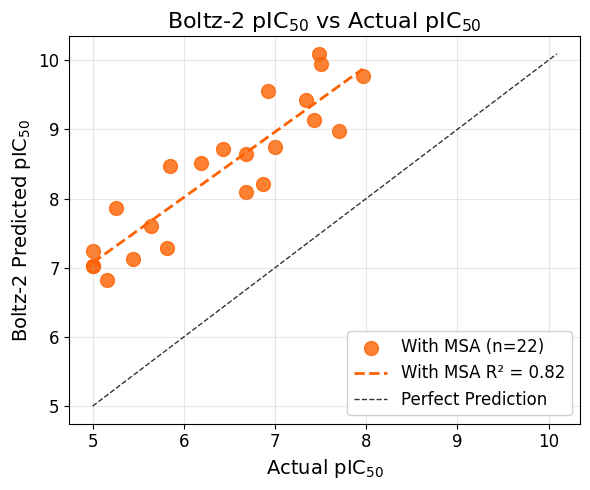

In [ ]:
ORANGE = (254/255, 97/255, 0) # from IBM colorblind friendly palette

# Create figure
plt.figure(figsize=(6, 5))

# Plot data and regression lines
x_values = results_df['pic50'].values.reshape(-1, 1)
y_values = results_df['boltz2_pic50'].values

# Remove any NaN values
valid_mask = ~(np.isnan(x_values.flatten()) | np.isnan(y_values))
x_clean = x_values[valid_mask].reshape(-1, 1)
y_clean = y_values[valid_mask]

if len(x_clean) > 1:  # Need at least 2 points for regression
    # Scatter plot
    plt.scatter(x_clean.flatten(),
                y_clean,
                color=ORANGE,
                alpha=0.8,
                s=100,
                label=f'With MSA (n={len(x_clean)})')

    # Fit linear regression
    regression_model = LinearRegression()
    regression_model.fit(x_clean, y_clean)

    # Calculate R-squared
    y_predicted = regression_model.predict(x_clean)
    r2_score_value = r2_score(y_clean, y_predicted)

    # Create regression line
    x_range = np.linspace(x_clean.min(), x_clean.max(), 100).reshape(-1, 1)
    y_range = regression_model.predict(x_range)

    # Plot regression line
    plt.plot(x_range.flatten(),
             y_range,
             color=ORANGE,
             linewidth=2,
             linestyle='--',
             label=f'With MSA R² = {r2_score_value:.2f}')

# Add diagonal reference line (perfect prediction)
min_val = min(results_df['pic50'].min(), results_df['boltz2_pic50'].min())
max_val = max(results_df['pic50'].max(), results_df['boltz2_pic50'].max())
plt.plot([min_val, max_val], [min_val, max_val],
         'k--', alpha=0.8, linewidth=1, label='Perfect Prediction')

plot_figure_path = f"{OUTPUT_DIR}/Boltz2_pIC50_vs_Actual_pIC50_for_{uniprot_id}_with_MSA_{MSA_STATUS}_{timestamp}.png"

# Formatting
plt.xlabel(r"Actual pIC$_{50}$", fontsize=14)
plt.ylabel(r"Boltz-2 Predicted pIC$_{50}$", fontsize=14)
plt.title(r"Boltz-2 pIC$_{50}$ vs Actual pIC$_{50}$", fontsize=16)
plt.legend(fontsize=12, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig(plot_figure_path, dpi=300)
plt.show()

 ## 2.7 Save plot figure to local machine

In [ ]:
files.download(plot_figure_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>